In [22]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib import colors
import cv2
from ultralytics import YOLO
from IPython.display import display
from PIL import Image, ImageDraw

### Load ply, cut in half, and visualize

In [23]:
# data_folder = "./example_001/"
data_folder = "./tmp4/"
pcd_file = "fused.ply"

pcd = o3d.io.read_point_cloud(data_folder+pcd_file)
points = np.asarray(pcd.points)


In [24]:
min_y = np.min(points[:, 1])
max_y = np.max(points[:, 1])
mid_way = (min_y + max_y) / 2

print(f"Min Y: {min_y}")
print(f"Max Y: {max_y}")
print(f"Mid Way: {mid_way}")

Min Y: -4.974679470062256
Max Y: 1.3582953214645386
Mid Way: -1.8081920742988586


In [ ]:
# Create mask for points below mid_way height
below_mid_mask = points[:, 1] > mid_way

# Filter points
below_mid_points = points[below_mid_mask]

# Create new point cloud with filtered points
below_mid_pcd = o3d.geometry.PointCloud()
below_mid_pcd.points = o3d.utility.Vector3dVector(below_mid_points)
below_mid_pcd.voxel_down_sample(voxel_size=0.09)

# Visualize the lower half of the point cloud
# o3d.visualization.draw_geometries([below_mid_pcd], window_name="Points Below Midway")

### Extract x, z points and create grid density histogram

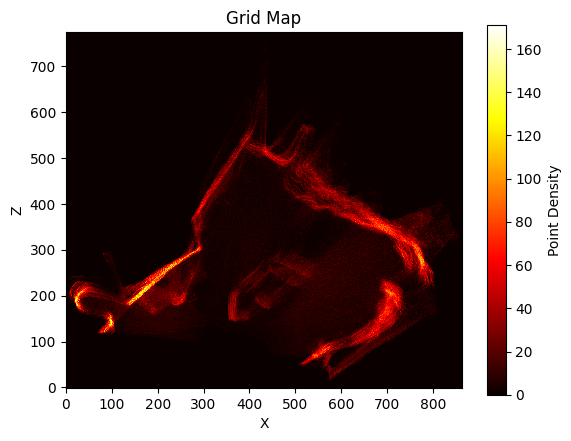

In [26]:
grid_resolution = 0.02

x_indices = np.floor(below_mid_points[:, 0] / grid_resolution).astype(int)
z_indices = np.floor(below_mid_points[:, 2] / grid_resolution).astype(int)

x_min, z_min = x_indices.min(), z_indices.min()
x_indices -= x_min
z_indices -= z_min

# empty grid
grid_shape = (x_indices.max() + 1, z_indices.max() + 1)
grid = np.zeros(grid_shape, dtype=int)


for x, z in zip(x_indices, z_indices):
    grid[x, z] += 1

plt.imshow(grid.T, origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar(label='Point Density')
plt.title('Grid Map')
plt.xlabel('X')
plt.ylabel('Z')
plt.show()


### Load camera poses, add to plot, visualize

In [27]:
camera_folder = data_folder + "camera"

npz_files = glob.glob(os.path.join(camera_folder, "*.npz"))
sorted_npz_files = sorted(npz_files)

# Load each npz file
npz_data = []
cam_positions = []

for npz_file in sorted_npz_files:
    data = np.load(npz_file)
    npz_data.append(data)
    cam_positions.append(data["pose"][:3, 3])
    print(f"Loaded {os.path.basename(npz_file)}")
    
cam_positions = np.array(cam_positions)


Loaded 000000.npz
Loaded 000001.npz
Loaded 000002.npz
Loaded 000003.npz
Loaded 000004.npz
Loaded 000005.npz
Loaded 000006.npz
Loaded 000007.npz
Loaded 000008.npz
Loaded 000009.npz
Loaded 000010.npz
Loaded 000011.npz
Loaded 000012.npz
Loaded 000013.npz
Loaded 000014.npz
Loaded 000015.npz
Loaded 000016.npz
Loaded 000017.npz
Loaded 000018.npz
Loaded 000019.npz
Loaded 000020.npz
Loaded 000021.npz
Loaded 000022.npz
Loaded 000023.npz
Loaded 000024.npz
Loaded 000025.npz
Loaded 000026.npz
Loaded 000027.npz
Loaded 000028.npz
Loaded 000029.npz
Loaded 000030.npz
Loaded 000031.npz
Loaded 000032.npz
Loaded 000033.npz
Loaded 000034.npz
Loaded 000035.npz
Loaded 000036.npz
Loaded 000037.npz
Loaded 000038.npz
Loaded 000039.npz
Loaded 000040.npz
Loaded 000041.npz
Loaded 000042.npz
Loaded 000043.npz
Loaded 000044.npz
Loaded 000045.npz
Loaded 000046.npz
Loaded 000047.npz
Loaded 000048.npz
Loaded 000049.npz
Loaded 000050.npz
Loaded 000051.npz
Loaded 000052.npz
Loaded 000053.npz
Loaded 000054.npz
Loaded 000

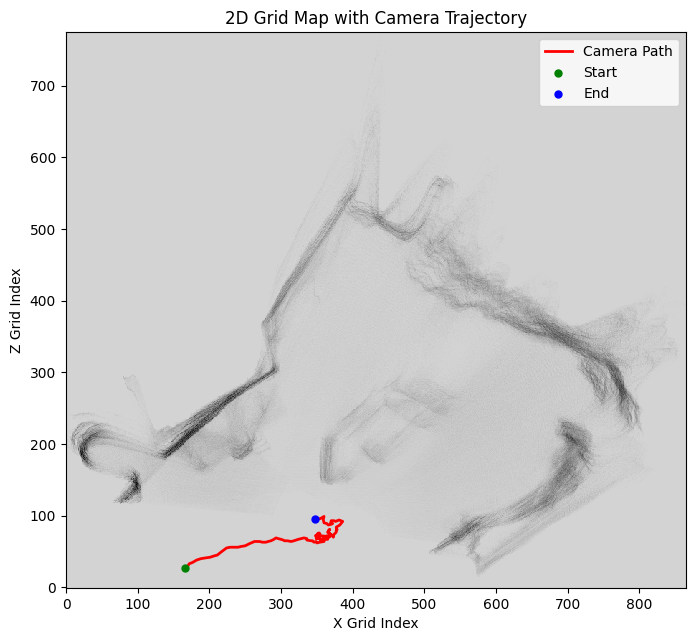

In [28]:
cam_x = np.floor(cam_positions[:, 0] / grid_resolution).astype(int) - x_min
cam_z = np.floor(cam_positions[:, 2] / grid_resolution).astype(int) - z_min

# this changes colors to gray
norm = colors.Normalize(vmin=0, vmax=np.max(grid))
cmap = colors.LinearSegmentedColormap.from_list('gray_to_black', ['#D3D3D3', 'black'])

plt.figure(figsize=(8, 8))
plt.imshow(grid.T, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')

# add camera x and y graph points
plt.plot(cam_x, cam_z, color='red', linewidth=2, label='Camera Path', zorder=1)
plt.scatter(cam_x[0], cam_z[0], color='green', s=25, label='Start', zorder=2)
plt.scatter(cam_x[-1], cam_z[-1], color='blue', s=25, label='End', zorder=2)

plt.legend()
plt.title("2D Grid Map with Camera Trajectory")
plt.xlabel("X Grid Index")
plt.ylabel("Z Grid Index")
plt.grid(False)
plt.show()


### Run Obj Detection for Annotations

In [29]:
model = YOLO("yolo11n.pt")

In [30]:
colors = [(255, 87, 51), (51, 255, 87), (51, 87, 255), (255, 51, 161), (161, 51, 255), (51, 255, 241), (241, 255, 51), (255, 140, 51), (51, 168, 255), (168, 255, 51), (255, 51, 51), (51, 255, 140), (140, 51, 255), (255, 51, 241), (241, 51, 255), (51, 255, 178), (178, 51, 255), (255, 178, 51), (51, 212, 255), (212, 255, 51), (255, 51, 102), (102, 51, 255), (51, 255, 102), (255, 102, 51), (51, 102, 255), (102, 255, 51), (255, 51, 204), (204, 51, 255), (51, 255, 204), (204, 255, 51), (255, 153, 51), (153, 51, 255), (51, 255, 153), (153, 255, 51), (255, 51, 51), (51, 255, 255), (255, 255, 51), (255, 51, 255), (51, 51, 255), (255, 170, 51), (170, 51, 255), (51, 255, 170), (170, 255, 51), (255, 68, 170), (68, 170, 255), (170, 255, 68), (255, 85, 170), (85, 170, 255), (170, 255, 85), (255, 102, 170), (102, 170, 255), (170, 255, 102), (255, 119, 170), (119, 170, 255), (170, 255, 119), (255, 136, 170), (136, 170, 255), (170, 255, 136), (255, 153, 170), (153, 170, 255), (170, 255, 153), (255, 170, 153), (170, 153, 255), (153, 255, 170), (255, 170, 187), (170, 187, 255), (187, 255, 170), (255, 187, 170), (187, 170, 255), (170, 255, 187), (255, 204, 170), (204, 170, 255), (170, 255, 204), (255, 221, 170), (221, 170, 255), (170, 255, 221), (255, 238, 170), (238, 170, 255), (170, 255, 238), (255, 255, 255)]

In [31]:
frames_folder = data_folder + "color"

jpg_files = glob.glob(os.path.join(frames_folder, "*.png"))
sorted_jpg_files = sorted(jpg_files)

In [32]:
data_by_frame = {}

output_folder = data_folder + "yolo_frames"
os.makedirs(output_folder, exist_ok=True)

for frame_i, img_src in enumerate(sorted_jpg_files):
    frame = cv2.imread(img_src)
    r = model.track(frame, persist=True, tracker="botsort.yaml")[0]
    
    
    ids = r.boxes.id.tolist() if r.boxes.id is not None else []
    xyxy = r.boxes.xyxy.tolist() if r.boxes.xyxy is not None else []
    names = [r.names[cls.item()] for cls in r.boxes.cls.int()]
    confs = r.boxes.conf.tolist() if r.boxes.conf is not None else []

    data_by_frame[frame_i] = {
      "ids": ids,
      "xyxy": xyxy,
      "names": names,
      "confs": confs
    }
    
    # saving frame data
    for i in range(len(xyxy)):
        x1, y1, x2, y2 = map(int, xyxy[i])
        class_name = names[i]
        conf = confs[i]
        obj_id = ids[i] if i < len(ids) else "?"

        label = f"{class_name} {obj_id} ({conf:.2f})"
        
        # Draw rectangle
        cv2.rectangle(frame, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
        
        # Put label above box
        cv2.putText(frame, label, (x1, y1 - 10),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.5,
                    color=(0, 255, 0),
                    thickness=2)

    # Save annotated frame
    output_path = os.path.join(output_folder, f"{frame_i:06d}.jpg")
    cv2.imwrite(output_path, frame)
    
    


0: 640x384 1 dining table, 1 cell phone, 43.2ms
Speed: 1.9ms preprocess, 43.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 dining table, 1 cell phone, 40.6ms
Speed: 1.1ms preprocess, 40.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 chair, 1 dining table, 1 cell phone, 39.8ms
Speed: 1.2ms preprocess, 39.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 chair, 1 dining table, 1 cell phone, 41.9ms
Speed: 1.2ms preprocess, 41.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 chair, 1 dining table, 46.1ms
Speed: 1.4ms preprocess, 46.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 chair, 1 dining table, 43.5ms
Speed: 1.3ms preprocess, 43.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 chair, 37.6ms
Speed: 1.2ms preprocess, 37.6ms inference, 1.9ms postprocess per image at shape (1, 3, 6

In [33]:
data_by_id = {}

for frame_i, data in data_by_frame.items():
    ids = data['ids']
    names = data['names']
    confs = data['confs']
    xyxy = data['xyxy']
    
    # For whatever reason some frames may be able to detect objects but no id is assigned so we will just skip over those frames for simplicity purpose rn
    if len(ids) == len(xyxy) == len(names) == len(confs):
        for id, name, conf, xyxy in zip(ids, names, confs, xyxy):
            if id not in data_by_id:
                data_by_id[id] = {
                    "frames": [],
                    "names": [],
                    "confs": [],
                    "xyxy": []
                }
            data_by_id[id]["frames"].append(frame_i)
            data_by_id[id]["names"].append(name)
            data_by_id[id]["confs"].append(conf)
            data_by_id[id]["xyxy"].append(xyxy)
            
        print(f"Frame {frame_i}:")
        print(f"Ids: {ids}")
        print(f"Class Names: {names}")
        print(f"Confidence Scores: {confs}")
        print(f"Bounding Box: {xyxy}")
        print("\n")

Frame 0:
Ids: [1.0, 2.0]
Class Names: ['dining table', 'cell phone']
Confidence Scores: [0.4301234483718872, 0.2683938443660736]
Bounding Box: [127.18576049804688, 104.75822448730469, 143.684326171875, 123.28337097167969]


Frame 1:
Ids: [1.0, 2.0]
Class Names: ['dining table', 'cell phone']
Confidence Scores: [0.5294899940490723, 0.10453895479440689]
Bounding Box: [96.90367126464844, 102.28418731689453, 114.4896240234375, 121.40369415283203]


Frame 2:
Ids: [1.0, 2.0, 3.0]
Class Names: ['dining table', 'cell phone', 'chair']
Confidence Scores: [0.46532586216926575, 0.31440404057502747, 0.8657247424125671]
Bounding Box: [230.16162109375, 220.8480224609375, 281.90093994140625, 345.1221008300781]


Frame 3:
Ids: [1.0, 2.0, 3.0]
Class Names: ['dining table', 'cell phone', 'chair']
Confidence Scores: [0.29043883085250854, 0.382622629404068, 0.9328110814094543]
Bounding Box: [204.218505859375, 206.2258758544922, 276.6927795410156, 348.338623046875]


Frame 4:
Ids: [1.0, 3.0]
Class Names: ['

In [34]:

data_by_id_cleaned = {}

for id, data in data_by_id.items():
  frames = data['frames']
  names = data['names']
  confs = data['confs']
  # bounding box (top-left-x, top-left-y, bottom-right-x, bottom-right-y)
  xyxy = data['xyxy']
  
  data_by_id_cleaned[id] = {
    "min_frame": frames[0],
    "max_frame": frames[-1],
    "frames": frames,
    "dominant_class": max(set(names), key=names.count),
    "confidence": confs,
    "average_confidence": sum(confs) / len(confs),
    "center_points": [((p[2] + p[0])/2, (p[3]+p[1])/2) for p in xyxy],
    "bb": xyxy
  }

In [35]:
data_by_id_cleaned

{1.0: {'min_frame': 0,
  'max_frame': 5,
  'frames': [0, 1, 2, 3, 4, 5],
  'dominant_class': 'dining table',
  'confidence': [0.4301234483718872,
   0.5294899940490723,
   0.46532586216926575,
   0.29043883085250854,
   0.543006956577301,
   0.21480350196361542],
  'average_confidence': 0.41219809899727505,
  'center_points': [(185.44153213500977, 287.0662155151367),
   (168.76569366455078, 287.5961227416992),
   (150.1881504058838, 288.8199234008789),
   (128.03004455566406, 292.58428955078125),
   (119.15771484375, 293.6103515625),
   (108.00957489013672, 298.5043258666992)],
  'bb': [[82.96549224853516,
    209.79893493652344,
    287.9175720214844,
    364.33349609375],
   [53.75447082519531,
    209.67433166503906,
    283.77691650390625,
    365.5179138183594],
   [22.562610626220703,
    210.55372619628906,
    277.8136901855469,
    367.08612060546875],
   [0.0, 213.85964965820312, 256.0600891113281, 371.3089294433594],
   [0.0, 207.50747680664062, 238.3154296875, 379.713226318

In [36]:
def image_to_world(u, v, depth, K, Tcw):
    """
    u, v: pixel coordinates
    depth: depth at (u, v) in meters
    K: (3x3) camera intrinsics
    Tcw: (4x4) camera-to-world pose
    Returns: (Xw, Yw, Zw) world coordinates
    """
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    # Camera coordinates
    Xc = (u - cx) * depth / fx
    Yc = (v - cy) * depth / fy
    Zc = depth

    # Homogeneous camera point
    Pc = np.array([Xc, Yc, Zc, 1.0])

    # World coordinates
    Pw = Tcw @ Pc

    return Pw[:3]

In [44]:
annotations = []
for key, value in data_by_id_cleaned.items():
  try:
    frames = value["frames"]
    min_frame = value["min_frame"]
    max_frame = value["max_frame"]
    center_point = value["center_points"][0]
    dominant_class = value["dominant_class"]
    confidence = value["confidence"]
    avg_confidence = value["average_confidence"]
    # print(min_frame, max_frame, center_point, dominant_class, confidence)
    
    frame_id = f"{min_frame:06d}"
    depth = np.load(data_folder+ "depth/" + frame_id + ".npy")[round(center_point[1]), round(center_point[0])]
    # depthConf = np.load("./tmp4/conf/" + frame_id + ".npy")[round(center_point[0]), round(center_point[1])]
    camera_data = np.load(data_folder+ "camera/" + frame_id + ".npz")
    K = camera_data["intrinsics"]
    pose = camera_data["pose"]

    real_world_point = image_to_world(center_point[0], center_point[1], depth, K, pose)
    x = real_world_point[0]
    z = real_world_point[2]
    x_normalized = np.floor(x / grid_resolution).astype(int) - x_min
    z_normalized = np.floor(z / grid_resolution).astype(int) - z_min
    
    grid_point = (x_normalized, z_normalized)
    annotations.append({
      "class": dominant_class,
      "confidence": avg_confidence,
      "real_world_point": real_world_point,
      "grid_point": grid_point,
    })
  except Exception as e:
    # print(e)
    continue

print(annotations)

[{'class': 'dining table', 'confidence': 0.41219809899727505, 'real_world_point': array([    0.40737,     0.30579,        4.41]), 'grid_point': (np.int64(186), np.int64(247))}, {'class': 'cell phone', 'confidence': 0.267489867284894, 'real_world_point': array([  -0.075747,     -1.2476,       3.943]), 'grid_point': (np.int64(162), np.int64(224))}, {'class': 'chair', 'confidence': 0.9073057266382071, 'real_world_point': array([     1.6861,     0.32353,      4.4245]), 'grid_point': (np.int64(250), np.int64(248))}, {'class': 'chair', 'confidence': 0.4502245247364044, 'real_world_point': array([     4.8314,      -1.906,      11.964]), 'grid_point': (np.int64(407), np.int64(625))}, {'class': 'couch', 'confidence': 0.28470874205231667, 'real_world_point': array([     2.8049,    -0.90494,      7.6054]), 'grid_point': (np.int64(306), np.int64(407))}, {'class': 'chair', 'confidence': 0.5778460303942362, 'real_world_point': array([     7.7874,     -1.6568,      8.2105]), 'grid_point': (np.int64(5

In [45]:
base_pcd = o3d.geometry.PointCloud()
base_pcd.points = o3d.utility.Vector3dVector(below_mid_points)
base_pcd = base_pcd.voxel_down_sample(voxel_size=0.09)

# Create small black spheres for each annotation point
black_spheres = []
sphere_radius = 0.1

for pt in [a["real_world_point"] for a in annotations]:
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=sphere_radius)
    sphere.paint_uniform_color([0.0, 0.0, 0.0])  # black
    sphere.translate(pt)  # move sphere to the point location
    black_spheres.append(sphere)

# Combine base point cloud with all black spheres
# o3d.visualization.draw_geometries(
#     [base_pcd] + black_spheres,
#     window_name="Point Cloud with Annotated Spheres"
# )


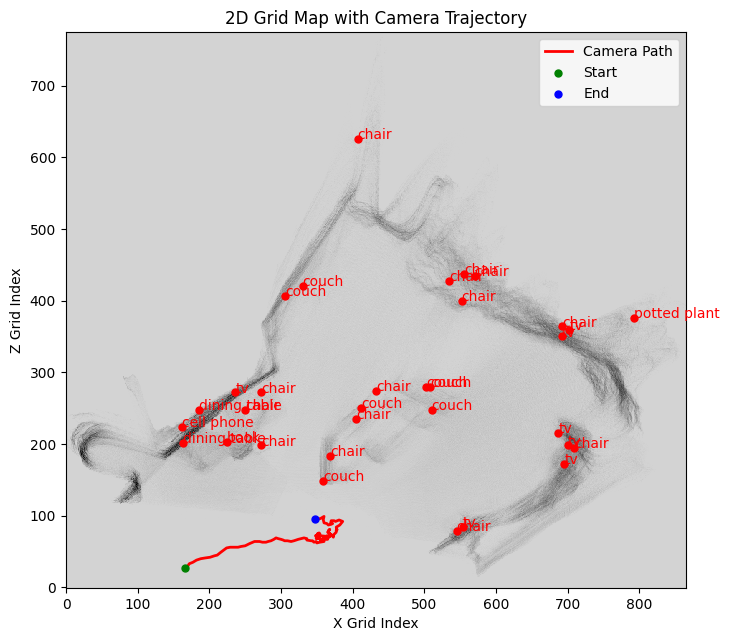

In [46]:
plt.figure(figsize=(8, 8))
plt.imshow(grid.T, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')

# add camera x and y graph points
plt.plot(cam_x, cam_z, color='red', linewidth=2, label='Camera Path', zorder=1)
plt.scatter(cam_x[0], cam_z[0], color='green', s=25, label='Start', zorder=2)
plt.scatter(cam_x[-1], cam_z[-1], color='blue', s=25, label='End', zorder=2)

# add real world point
for annotation in annotations:
  # if annotation["confidence"] < 0.5:
  #   continue
  plt.scatter(annotation["grid_point"][0], annotation["grid_point"][1], color='red', s=25)
  plt.text(annotation["grid_point"][0], annotation["grid_point"][1], annotation["class"], color='red', fontsize=10)

plt.legend()
plt.title("2D Grid Map with Camera Trajectory")
plt.xlabel("X Grid Index")
plt.ylabel("Z Grid Index")
plt.grid(False)
plt.show()

In [47]:
annotations3 = []

for key, value in data_by_id_cleaned.items():
    try:
        frames = value["frames"]
        center_point = value["center_points"][0]
        dominant_class = value["dominant_class"]
        yolo_confidences = value["confidence"]  # Array/list of YOLO confidences, one per frame

        best_annotation = None
        max_combined_conf = -1

        for i, frame in enumerate(frames):
            try:
                yolo_confidence = yolo_confidences[i]  # get confidence for current frame
                
                frame_id = f"{frame:06d}"
                depth_map = np.load(data_folder + "depth/" + frame_id + ".npy")
                conf_map = np.load(data_folder + "conf/" + frame_id + ".npy")

                u = round(center_point[0])
                v = round(center_point[1])

                # Skip if out of bounds
                if not (0 <= u < conf_map.shape[0] and 0 <= v < conf_map.shape[1]):
                    continue

                depth_conf = conf_map[u, v]

                combined_conf = yolo_confidence * depth_conf

                if combined_conf > max_combined_conf:
                    depth = depth_map[u, v]

                    if depth == 0 or np.isnan(depth):
                        continue

                    camera_data = np.load(data_folder + "camera/" + frame_id + ".npz")
                    K = camera_data["intrinsics"]
                    pose = camera_data["pose"]

                    real_world_point = image_to_world(center_point[0], center_point[1], depth, K, pose)
                    x = real_world_point[0]
                    z = real_world_point[2]
                    x_normalized = np.floor(x / grid_resolution).astype(int) - x_min
                    z_normalized = np.floor(z / grid_resolution).astype(int) - z_min

                    best_annotation = {
                        "class": dominant_class,
                        "yolo_confidence": yolo_confidence,
                        "depth_confidence": depth_conf,
                        "combined_confidence": combined_conf,
                        "real_world_point": real_world_point,
                        "grid_point": (x_normalized, z_normalized),
                    }
                    max_combined_conf = combined_conf

            except Exception:
                continue  # Skip problematic frame

        if best_annotation:
            annotations3.append(best_annotation)

    except Exception:
        continue

print(annotations3)


[{'class': 'dining table', 'yolo_confidence': 0.5294899940490723, 'depth_confidence': np.float32(33.631386), 'combined_confidence': np.float32(17.807482), 'real_world_point': array([    0.78498,     0.38571,      5.3182]), 'grid_point': (np.int64(205), np.int64(292))}, {'class': 'cell phone', 'yolo_confidence': 0.382622629404068, 'depth_confidence': np.float32(52.837875), 'combined_confidence': np.float32(20.216967), 'real_world_point': array([    0.74984,     -1.3258,      4.2707]), 'grid_point': (np.int64(203), np.int64(240))}, {'class': 'chair', 'yolo_confidence': 0.9328110814094543, 'depth_confidence': np.float32(44.814087), 'combined_confidence': np.float32(41.803078), 'real_world_point': array([     1.4383,     0.23106,      3.1644]), 'grid_point': (np.int64(237), np.int64(185))}, {'class': 'chair', 'yolo_confidence': 0.5502173900604248, 'depth_confidence': np.float32(36.823322), 'combined_confidence': np.float32(20.260832), 'real_world_point': array([       4.75,      -1.674,   

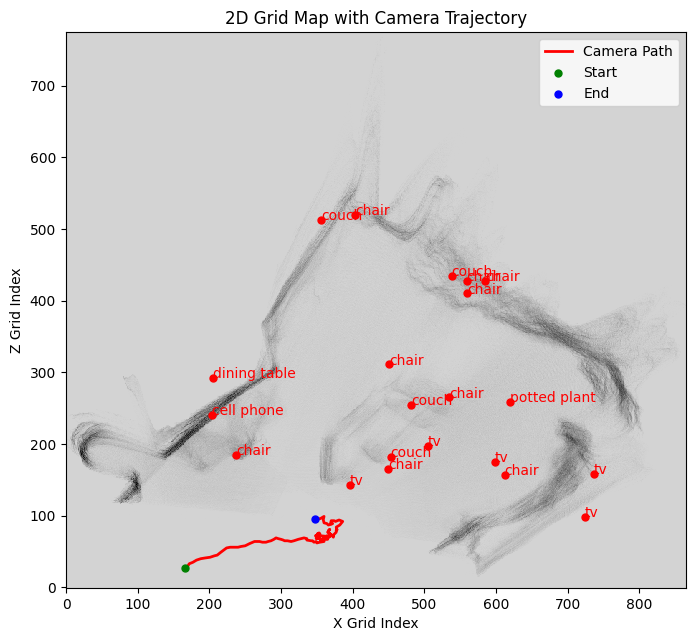

In [48]:
plt.figure(figsize=(8, 8))
plt.imshow(grid.T, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')

# add camera x and y graph points
plt.plot(cam_x, cam_z, color='red', linewidth=2, label='Camera Path', zorder=1)
plt.scatter(cam_x[0], cam_z[0], color='green', s=25, label='Start', zorder=2)
plt.scatter(cam_x[-1], cam_z[-1], color='blue', s=25, label='End', zorder=2)

# add real world point
for annotation in annotations3:
  # if annotation["confidence"] < 0.5:
  #   continue
  plt.scatter(annotation["grid_point"][0], annotation["grid_point"][1], color='red', s=25)
  plt.text(annotation["grid_point"][0], annotation["grid_point"][1], annotation["class"], color='red', fontsize=10)

plt.legend()
plt.title("2D Grid Map with Camera Trajectory")
plt.xlabel("X Grid Index")
plt.ylabel("Z Grid Index")
plt.grid(False)
plt.show()

In [49]:
def weighted_patch_average(depth_map, conf_map, center_u, center_v, patch_size=3):
    half_patch = patch_size // 2

    u_min = max(center_u - half_patch, 0)
    u_max = min(center_u + half_patch + 1, depth_map.shape[0])
    v_min = max(center_v - half_patch, 0)
    v_max = min(center_v + half_patch + 1, depth_map.shape[1])

    depth_patch = depth_map[u_min:u_max, v_min:v_max]
    conf_patch = conf_map[u_min:u_max, v_min:v_max]

    # Mask out invalid depths (0 or nan)
    valid_mask = (depth_patch > 0) & (~np.isnan(depth_patch))
    if np.sum(valid_mask) == 0:
        return None, None  # no valid depth in patch

    depth_patch = depth_patch[valid_mask]
    conf_patch = conf_patch[valid_mask]

    # Confidence-weighted average depth
    weighted_depth = np.sum(depth_patch * conf_patch) / np.sum(conf_patch)

    # Average confidence
    avg_conf = np.mean(conf_patch)

    return weighted_depth, avg_conf


annotations3 = []

for key, value in data_by_id_cleaned.items():
    try:
        frames = value["frames"]
        center_point = value["center_points"][0]
        dominant_class = value["dominant_class"]
        yolo_confidences = value["confidence"]  # per-frame YOLO confidence

        best_annotation = None
        max_combined_conf = -1

        for i, frame in enumerate(frames):
            try:
                yolo_confidence = yolo_confidences[i]

                frame_id = f"{frame:06d}"
                depth_map = np.load(data_folder + "depth/" + frame_id + ".npy")
                conf_map = np.load(data_folder + "conf/" + frame_id + ".npy")

                u = round(center_point[0])
                v = round(center_point[1])

                if not (0 <= u < depth_map.shape[0] and 0 <= v < depth_map.shape[1]):
                    continue

                weighted_depth, avg_depth_conf = weighted_patch_average(depth_map, conf_map, u, v, patch_size=3)

                if weighted_depth is None or avg_depth_conf is None:
                    continue

                combined_conf = yolo_confidence * avg_depth_conf

                if combined_conf > max_combined_conf:
                    if weighted_depth == 0 or np.isnan(weighted_depth):
                        continue

                    camera_data = np.load(data_folder + "camera/" + frame_id + ".npz")
                    K = camera_data["intrinsics"]
                    pose = camera_data["pose"]

                    real_world_point = image_to_world(center_point[0], center_point[1], weighted_depth, K, pose)
                    x = real_world_point[0]
                    z = real_world_point[2]
                    x_normalized = np.floor(x / grid_resolution).astype(int) - x_min
                    z_normalized = np.floor(z / grid_resolution).astype(int) - z_min

                    best_annotation = {
                        "class": dominant_class,
                        "yolo_confidence": yolo_confidence,
                        "depth_confidence": avg_depth_conf,
                        "combined_confidence": combined_conf,
                        "real_world_point": real_world_point,
                        "grid_point": (x_normalized, z_normalized),
                    }
                    max_combined_conf = combined_conf

            except Exception:
                continue

        if best_annotation:
            annotations3.append(best_annotation)

    except Exception:
        continue

print(annotations3)


[{'class': 'dining table', 'yolo_confidence': 0.5294899940490723, 'depth_confidence': np.float32(30.443918), 'combined_confidence': np.float32(16.119751), 'real_world_point': array([    0.78611,     0.38635,      5.3266]), 'grid_point': (np.int64(205), np.int64(293))}, {'class': 'cell phone', 'yolo_confidence': 0.382622629404068, 'depth_confidence': np.float32(52.7707), 'combined_confidence': np.float32(20.191263), 'real_world_point': array([    0.74984,     -1.3258,      4.2708]), 'grid_point': (np.int64(203), np.int64(240))}, {'class': 'chair', 'yolo_confidence': 0.9328110814094543, 'depth_confidence': np.float32(44.592773), 'combined_confidence': np.float32(41.596634), 'real_world_point': array([     1.4382,     0.23104,      3.1641]), 'grid_point': (np.int64(237), np.int64(185))}, {'class': 'chair', 'yolo_confidence': 0.5502173900604248, 'depth_confidence': np.float32(36.84621), 'combined_confidence': np.float32(20.273426), 'real_world_point': array([     4.7497,     -1.6738,      

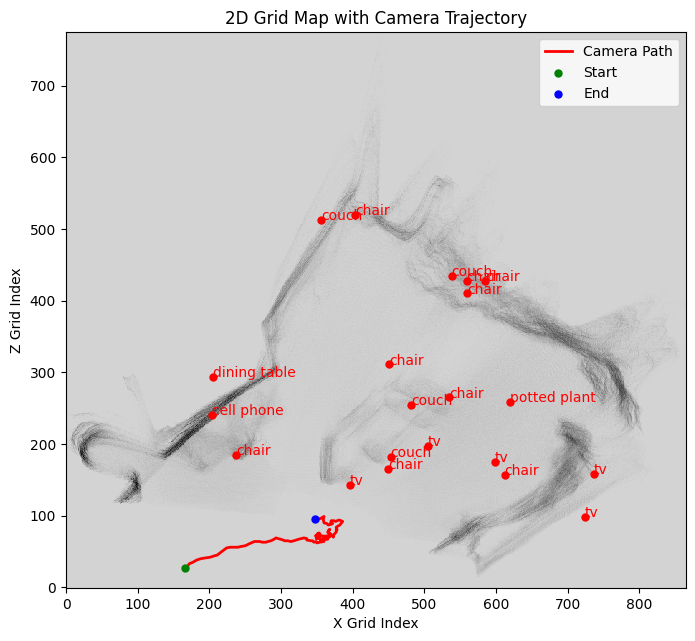

In [50]:
plt.figure(figsize=(8, 8))
plt.imshow(grid.T, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')

# add camera x and y graph points
plt.plot(cam_x, cam_z, color='red', linewidth=2, label='Camera Path', zorder=1)
plt.scatter(cam_x[0], cam_z[0], color='green', s=25, label='Start', zorder=2)
plt.scatter(cam_x[-1], cam_z[-1], color='blue', s=25, label='End', zorder=2)

# add real world point
for annotation in annotations3:
  # if annotation["confidence"] < 0.5:
  #   continue
  plt.scatter(annotation["grid_point"][0], annotation["grid_point"][1], color='red', s=25)
  plt.text(annotation["grid_point"][0], annotation["grid_point"][1], annotation["class"], color='red', fontsize=10)

plt.legend()
plt.title("2D Grid Map with Camera Trajectory")
plt.xlabel("X Grid Index")
plt.ylabel("Z Grid Index")
plt.grid(False)
plt.show()